# Tutorial on Encoding Models with Word Embeddings
for NeuroHackademy 2020, by Alex Huth


In [1]:
# Load some basic stuff we'll need later
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Part 2: Regularized (Ridge) Regression

Remember when we talked about the noise term, $\epsilon(t)$? We said it was any part of $y(t)$ that couldn't be predicted from $x(t)$. We can write this mathematically as the difference between $y(t)$ and the predicted value based on $x(t)$ and our estimated weights (this comes from re-arranging the equation listed under "Define the model" above):

$$\epsilon(t) = y(t) - x(t) \beta_{OLS}$$

Huh. When we write it this way, it looks a lot like the loss function $\mathcal{L}(\beta)$, doesn't it? In fact, the loss function is exactly the sum of the squared errors. This means our OLS regression model made the assumption that _$\epsilon(t)$ is as small as possible_, because we selected $\beta_{OLS}$ to minimize the size of the loss.

This all seems sensible in some situations. We don't know a priori which parts of $y(t)$ are signal (i.e. predictable from $x(t)$) and which parts are noise, so why not try to predict as much as possible? Well, it's time for 

<span style="color:red; font-family:Snell Roundhand, cursive; font-size: 24pt">**A CAUTIONARY TALE**</span>.

<span style="color:red; font-style:italic">
A young neuroscientist is performing an experiment.
</span>

<span style="color:red; font-style:italic">
"I just scanned a brain, and my scanning machine gave me big lists of numbers," they said, "I _know_ that the data from the scanning machine is always noisy, but I'm just going to try to fit a model that makes my total error small. What could be finer than finding small error?"
<span>

In [2]:
cautionary_data = np.load("/Users/clmnlab/Downloads/data/we_word_embeddings/a_cautionary_tale.npz")

X_train = cautionary_data["X_train"]
X_test = cautionary_data["X_test"]
Y_train = cautionary_data["Y_train"]
Y_test = cautionary_data["Y_test"]
beta_true = cautionary_data["beta_true"]

In [3]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape, beta_true.shape

((100, 98), (25, 98), (100,), (25,), (98,))

<span style="color:red; font-style:italic">
The young neuroscientist diligently fired up their Jupyter notebook and ran an ordinary least squares regression using the noisy data. At first, the result was amazing! The loss was tiny! The model explained 99.9% of the variance in the training dataset! This seemed like the breakthrough that the young neuroscientist had been waiting for.
</span>

In [4]:
beta_estimate = np.linalg.lstsq(X_train, Y_train)[0]

training_loss = ((X_train.dot(beta_estimate) - Y_train)**2).sum()
print("training loss:", training_loss)
print("training R^2:", 1 - training_loss / (Y_train**2).sum())

training loss: 2.5866841305830968
training R^2: 0.9997128446796295


/usr/local/anaconda3/envs/sampark/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


<span style="color:red; font-style:italic">
But upon further reflection, the young neuroscientist realized that something was amiss. The result was not as good as it seemed to be. The young neuroscientist exclaimed, "What's this? Can it be? My regression weights make no sense! Some values are huge, some values are tiny, and if I try to predict on held-out test data, the result is abhorrent! Oh, woe is me! Why did I try to exactly minimize error?? _WHY??_"
</span>

In [5]:
print("estimated beta:", beta_estimate)

Y_test_pred = X_test.dot(beta_estimate)
print("Correlation between true & predicted Y_test:", np.corrcoef(Y_test, Y_test_pred)[0,1])

estimated beta: [ -4594.58174457  -5794.05369566 -16106.83482789   2537.96474564
 -20926.22612195   6882.38422856   1947.54105308  -8592.97158243
   1881.4021397   14220.50340837   7104.77141908   2674.25812034
   -556.8779624   -5135.58455923  25405.97398904 -12923.10730094
   7244.48361127 -15465.88839356  23843.98434501   5982.93541493
    657.83643116    303.09282762   4328.59634515   -720.03371849
  -6852.75144497  -5656.20832979   9576.27308336    755.25890776
 -11696.10420832   2533.25589156   9624.41909331  11002.24874853
  -1752.55711419  -4369.5049089  -10505.11711087  12208.6203449
   5706.6515336     620.95407088   2800.01839107    781.33987599
  12661.99278062  -1137.71995329 -16021.34548968   -834.93342626
   -404.27049909    514.11979727   9724.52766708  16061.11955206
    969.98874988   4597.33134751   5796.7067284   16107.60840224
  -2538.85103563  20926.72555763  -6885.37956355  -1947.84711155
   8596.0629129   -1880.72199485 -14219.07811462  -7108.85598295
  -2673.14

I hope this sorry story has convinced you that perfectly minimizing error can cause problems. And the alternative viewpoint just seems like common sense: if you _know_ that your data are noisy, then it just doesn't make sense to make your noise term as small as possible--especially if "as small as possible" might mean that you could have _zero noise_.

_(Aside: under what situations would you expect the OLS loss to become exactly zero?)_

The solution to this problem is **regularization**, which is a family of techniques for adding extra constraints to regression models that balance against simply minimizing loss. The particular technique that we will discuss in detail today is called **ridge regression** or [**Tikhonov regularization**](https://en.wikipedia.org/wiki/Tikhonov_regularization).

### Intuition behind ridge regression
The problem with OLS regression is that it is _overconfident_ in its estimation of the weights $\beta_{OLS}$. While attempting to minimize loss, OLS will allow the weights to take on any values, even extreme and bizarre values that are incredibly unlikely to accurately reflect reality. Ridge regression solves this problem by forcing the values in $\beta$ to be small (i.e. close to zero).

This is roughly equivalent to assuming that the noise term, $\epsilon(t)$, is large (or, at least, larger than it would have otherwise been). You can see this by thinking about the equation for the noise term: $\epsilon(t) = y(t) - x(t) \beta$. We know that $\epsilon(t)$ really shouldn't be any bigger than $y(t)$--worst case we can set $\beta=0$ and then we get an exact equivalence. If weights $\beta_{OLS}$ exactly minimize the size of the noise term, then making the weights smaller will necessarily make the noise term bigger.

### Ridge regression
The simplest way to describe ridge regression mathematically is including a **penalty** on the size of the weights in the loss function. Specifically, ridge regression penalizes the sum of the squared weights, leading to a new and improved loss function that we'll call $\mathcal{L}_{ridge}(\beta)$:

$$ \mathcal{L}_{ridge}(\beta) = \sum_{t=1}^T (y(t) - x(t) \beta)^2 + \lambda \sum_{i=1}^p \beta_i^2 $$

or, in fancy linear algebra terms:

$$ \mathcal{L}_{ridge}(\beta) = (Y - X\beta)^\top (Y - X \beta) + \lambda \beta^\top \beta $$

The first term on the right hand side of this equation is the same squared error loss that we used before for OLS. The second term is the sum of the squares of all the weights in $\beta$, multiplied by a scalar variable $\lambda$ that we will call the **ridge coefficient**.

The ridge coefficient $\lambda$ determines the _strength_ of the regularization that's applied in ridge regression: 
* If you give $\lambda$ a large value, then the penalty term will be big relative to the loss, and the resulting weights will be very small. (In the limit of very large $\lambda$ you will force the weights to be almost exactly zero!) 
* If you give $\lambda$ a small value, then the penalty term will be small relative to the loss, and the resulting weights will not be too different from the OLS weights. (In the limit of $\lambda \rightarrow 0$, the penalty term will be zero and you'll get back exactly the OLS solution!)

To get the ridge regression weights, $\beta_{ridge}$, you minimize the ridge loss function. We don't need to go through the full derivation of the solution (though it's pretty fun, and easy to do based on the matrix calculus we did for the OLS solution!), so let's just take a look at the answer:

$$ \beta_{ridge} = (X^\top X + \lambda I)^{-1} X^\top Y $$

The only difference between this and the previous $\beta_{OLS}$ solution is that we added the factor $\lambda I$ (where $I$ is the identity matrix, the linear algebra equivalent of the number 1) inside the matrix inverse. Pretty simple! 

Let's try it out on the data from our cautionary tale.

In [6]:
# let's start by picking a lambda. THIS IS NOT HOW THIS IS USUALLY DONE! This is just illustrative
ridge_lambda = 10.0

# then we'll compute the ridge weights using exactly the formula listed above
# (as before, this is not used in practice. It's slow and numerically unstable. But simple and clear!)
beta_estimate_ridge = np.linalg.inv(X_train.T.dot(X_train) + ridge_lambda * np.eye(98)).dot(X_train.T).dot(Y_train)

In [7]:
# before doing more, let's compare the weights we get from ridge to the OLS weights & true weights
print("ridge estimated beta:", beta_estimate_ridge)
print("OLS estimated beta:", beta_estimate)
print("true beta:", beta_true)

# you should see that the size of the ridge estimates is much closer to the original weights, which is good!

ridge estimated beta: [ 1.20284592  0.54358022 -0.17076853 -0.46913852  0.04712979 -0.43252916
 -0.46940385  0.75993806 -0.66024964  0.05161744 -1.28231356  0.14639374
  1.08433341  1.07531835  0.15202215 -0.43115172  0.42039943  0.19601658
 -0.25279569 -0.67608631  0.75461698 -0.36126768  0.37316565 -0.57848406
 -0.29988382 -0.28430522  0.29505655  0.19701606 -0.43751896 -0.30376373
 -0.42344552  0.34901169 -1.70650378  0.27316785 -0.42136402  0.20792123
 -0.36047633 -0.72054648  1.11409482 -0.31659404 -0.47916971  0.26895738
  0.54207873  0.8692063  -0.00460897 -0.40236788 -1.09188709 -0.45186825
  0.88325812  1.20273579  0.54385658 -0.1706784  -0.46920649  0.04702301
 -0.43253862 -0.46943782  0.75993798 -0.66039318  0.05155487 -1.28224771
  0.14634859  1.08420573  1.07530732  0.15183459 -0.43115928  0.42039769
  0.19616878 -0.25263899 -0.67629854  0.75444664 -0.36124037  0.37313815
 -0.57852429 -0.30003918 -0.28429678  0.29506545  0.19694568 -0.4374332
 -0.30351455 -0.42354956  0.34

In [8]:
# Now let's compute the training loss
training_loss_ridge = ((X_train.dot(beta_estimate_ridge) - Y_train)**2).sum()
print("training loss:", training_loss_ridge)
print("training R^2:", 1 - training_loss_ridge / (Y_train**2).sum())

# the loss value should be bigger than before (about 104 vs. 2.5)
# and the training R^2 should be smaller than before (about 0.988 instead of 0.999)
# why?

training loss: 104.2307280153736
training R^2: 0.988429044063854


In [9]:
# finally let's test how well our model generalizes to the test dataset
Y_test_pred = X_test.dot(beta_estimate_ridge)
print("Correlation between true & predicted Y_test:", np.corrcoef(Y_test, Y_test_pred)[0,1])

# this should be MUCH HIGHER than before! (0.6 vs. 0.03)

Correlation between true & predicted Y_test: 0.6025282035249678


## Ridge regression for an fMRI analysis

Let's try to use this method now for the same [fMRI experiment](https://www.nature.com/articles/nature17637) that we tried with OLS. The model will be essentially identical to the OLS model, the only difference being that we will use ridge regression.



In [10]:
# let's load up the feature matrices
# these were stored as "sparse" matrices in order to save space
# but we'll convert them back to normal matrices in order to use them in our regression
from scipy import sparse
training_features = sparse.load_npz('/Users/clmnlab/Downloads/data/we_word_embeddings/indicator_Rstim.npz').todense().A
test_features = sparse.load_npz('/Users/clmnlab/Downloads/data/we_word_embeddings/indicator_Pstim.npz').todense().A

# and the brain responses
import tables
response_tf = tables.open_file('/Users/clmnlab/Downloads/data/we_word_embeddings/small-fmri-responses.hdf5')
training_resp = response_tf.root.zRresp.read()
test_resp = response_tf.root.zPresp.read()
brain_mask = response_tf.root.mask.read()
response_tf.close()

# as before, to accurately predict BOLD responses we need to account for hemodynamic delays
# we'll do that here by creating multiple time-shifted versions of the same stimulus
# this is called a finite impulse response or FIR model

from util import make_delayed
delays = [1,2,3,4]

del_training_features = make_delayed(training_features, delays)
del_test_features = make_delayed(test_features, delays)

In [11]:
# # If we were doing this for real, we would run this part, which uses cross-validation
# # to find the best lambda for each voxel.
# # But that's time-consuming and annoying, so we're going to skip it here.

# from ridge import bootstrap_ridge
# import logging
# logging.basicConfig(level=logging.INFO)

# alphas = np.logspace(0, 2, 10) # Equally log-spaced alphas between 10 and 1000

# wt, corr, alphas, bscorrs, valinds = bootstrap_ridge(del_training_features, training_resp, 
#                                                      del_test_features, test_resp,
#                                                      alphas, nboots=1, chunklen=40, nchunks=20,
#                                                      singcutoff=1e-10, single_alpha=True)

In [12]:
# to fit this ridge model we're going to use some code I wrote instead of the simple equation above
# this code is part of a package that does the really hard part of ridge regression,
# which is choosing the best lambda (called alpha here, apologies)
# here we are skipping that step, and just using a value that I know works pretty well
# if you want to see how the more complicated procedure works, 
# check out the `bootstrap_ridge` function in ridge.py

from ridge import ridge
beta_ridge = ridge(del_training_features, training_resp, alpha=15.)

In [13]:
beta_ridge.shape
# as before, should be total number of features (10808) by number of voxels (5156)

(10808, 5156)

In [14]:
# now let's test our regression models on the held-out test data
pred_test_resp = del_test_features.dot(beta_ridge)

import npp # a set of convenience functions I think are missing from numpy :)

test_correlations = npp.mcorr(test_resp, pred_test_resp)

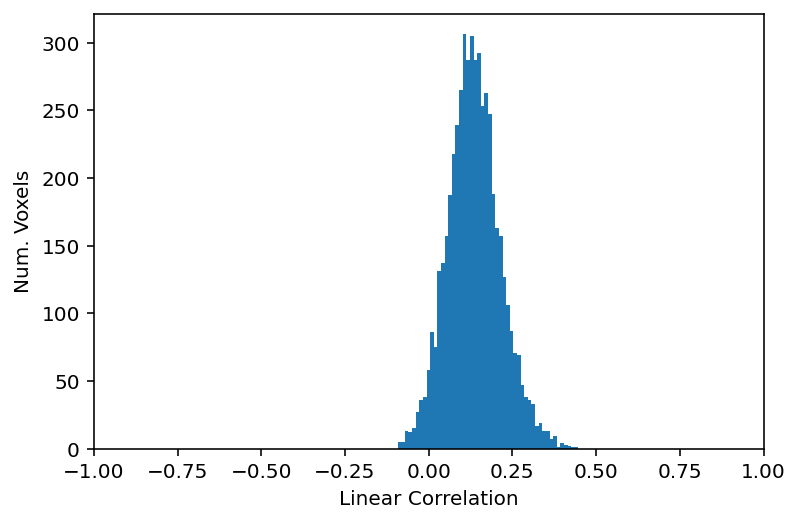

In [15]:
# let's look at the histogram of correlations!
plt.hist(test_correlations, 50)
plt.xlim(-1, 1)
plt.xlabel("Linear Correlation")
plt.ylabel("Num. Voxels");

This looks much better than before! We now have much bigger positive correlations than negative ones. This model kind of works!

FileNotFoundError: [Errno 2] No such file or directory: 'build/bdist.macosx-10.9-x86_64/wheel/pycortex-1.2.0.data/data/share/pycortex/db/S1/surfaces'

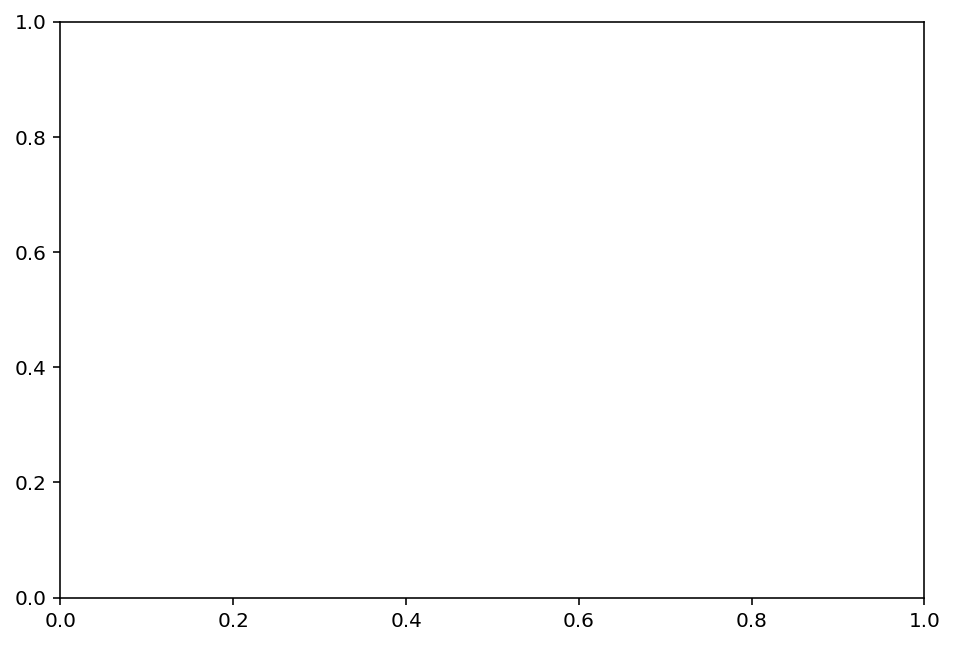

In [16]:
# let's also look at a brain map of the correlations!

import cortex

corr_volume = cortex.Volume(test_correlations, 'S1', 'fullhead', mask=brain_mask, vmin=-0.3, vmax=0.3, cmap='RdBu_r')
cortex.quickshow(corr_volume, with_curvature=True);

In [ ]:
# you can also look at it in 3D!

cortex.webshow(corr_volume, open_browser=False)

### Interpreting ridge regression as a "Gaussian prior"

So we've introduced ridge regression as a "penalty" on the loss function, but there's another way to think about ridge regression that is pretty useful in some situations. I want to note that this second interpretation is _exactly mathematically equivalent_ to what you've already seen, it's just a different way of thinking about it.

Remember Bayes' rule? $P(a|b) = \frac{P(b|a) P(a)}{P(b)}$, right? It turns out we can use Bayes' rule to derive ridge regression if we plug in the right variables in the right places. To do this we kind of have to go back to the beginning, but I think it's a much quicker trip once you've already gotten to this point once.

From a Bayesian viewpoint, the goal of regression is to find the most probably set of weights ($\beta$) given the observed data ($x(t), y(t)$). Mathematically, that means we're trying to find the set of weights $\beta$ that maximize $P(\beta | x(t), y(t))$ (read as "probability of $\beta$ given $x(t)$ and $y(t)$").

We don't really know what $P(\beta | x(t),y(t))$ is—that's not how we defined our regression model—but we DO know what $P(y(t) | x(t), \beta)$ is! The assumptions that we've been working with so far (squared error loss, etc.), imply that $P(y(t) | x(t), \beta)$ is actually a Gaussian distribution (aka Normal distribution). The mean of this distribution is (we assume) $x(t) \beta$, and it has some variance that we don't know ahead of time (this is the size of the noise term $\epsilon(t)$). We can write that like this:

$$ P(y(t) | x(t), \beta) = \mathcal{N}(x(t) \beta, \sigma^2), $$
where:
* $\mathcal{N}(x(t) \beta, \sigma^2)$ denotes a Normal distribution with mean $x(t) \beta$ and variance $\sigma^2$.
* $\sigma^2$ is the size of the noise. We don't know what this is yet!

Ok now we kind of know what $P(y(t) | x(t), \beta)$ is, and we know Bayes' rule. We can combine these things to figure out $P(\beta | y(t), x(t))$, which is the thing we actually want to maximize! Let's see how that goes..

$$ P(\beta | y(t), x(t)) = \frac{P(y(t) | x(t), \beta) P(\beta)}{P(y(t))} $$

Huh ok. Bayes' rule says that in order to get the thing we want ($P(\beta | y(t), x(t))$), we take the thing we know ($P(y(t) | x(t), \beta)$), multiply it by some weird new thing ($P(\beta)$), and then divide it by some other weird new thing ($P(y(t)$). Let's step through these different terms, what they mean, and how we can handle them:
* $P(y(t) | x(t), \beta)$. This is the thing we already know. It's sometimes called the "likelihood" function. We're modeling it as a Gaussian distribution. All good!
* $P(\beta)$. This is a new one. It's called the "prior" distribution on $\beta$. Think of it as "given absolutely no information about any of the data, what values of $\beta$ do we think are more or less likely?" (Foreshadowing: _this is where the magic will happen._)
* $P(y(t))$. This is also a new one. Fortunately, we can ignore it entirely! It doesn't matter one bit what the value of this function is, because it's independent of $\beta$, so our choice of the best $\beta$ is unaffected by it! Whew.

So clearly the most important new thing here is the prior, $P(\beta)$. **Let's suppose that $P(\beta)$ is another Gaussian distribution.** That is, let's say that $P(\beta) = \mathcal{N}(0, \lambda^{-1} I)$, a multivariate Gaussian distribution (because $\beta$ typically is a vector containing more than one value) with mean zero and covariance $\lambda^{-1} I$. You may have an inkling of where this is heading now..

Let's go back to our full expression for $P(\beta | y(t), x(t))$ (which is called the posterior distribution on $\beta$), plug some things in, and see what happens!

$$\begin{eqnarray}
P(\beta | y(t), x(t)) & = & \frac{P(y(t) | x(t), \beta) P(\beta)}{P(y(t))} \\
P(\beta | y(t), x(t)) & \propto & P(y(t) | x(t), \beta) P(\beta) \;\mbox{ (dropping the denominator)}\\
P(\beta | y(t), x(t)) & \propto & e^{-\frac{1}{2 \sigma^2} (y(t) - x(t)\beta)^2} e^{-\frac{1}{2} \beta^\top (\lambda^{-1} I)^{-1} \beta} \; \mbox{ (plugging in the definition of a Gaussian distribution)} \\
P(\beta | y(t), x(t)) & \propto & e^{-\frac{1}{2 \sigma^2} (y(t) - x(t)\beta)^2 -\frac{1}{2} \beta^\top (\lambda^{-1} I)^{-1} \beta} \;\mbox{ (combining exponentials)}\\
P(\beta | y(t), x(t)) & \propto & e^{-\frac{1}{2 \sigma^2} (y(t) - x(t)\beta)^2 -\frac{1}{2} \lambda \beta^\top \beta}\\
\end{eqnarray}$$

Alright that was a wild ride, but we ended up with something pretty interesting. The most important thing here is to look at the exponent in our new expression.. does it look familiar? It should, because it's pretty much the same as the ridge loss function (or, at least, the negative of the ridge loss function)! Recall that our goal here is to maximize the probability of $\beta$ given $y(t)$ and $x(t)$. This equation shows us that maximizing that probability is _exactly equivalent_ to minimizing the ridge loss function. The prior $P(\beta)$ and the penalty term in the loss function $\lambda \beta^\top \beta$ _mean exactly the same thing_!